In [1]:
import torch
from torch.utils.data import Dataset
import glob
import numpy as np
import os
from PIL import Image
from torchvision import transforms as T

from datasets.ray_utils import *
from datasets.colmap_utils import \
    read_cameras_binary, read_images_binary, read_points3d_binary

/home2/sdokania/.local/lib/python3.8/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


In [2]:
import cv2
import matplotlib.pyplot as plt

In [3]:

def normalize(v):
    """Normalize a vector."""
    return v/np.linalg.norm(v)


def average_poses(poses):
    """
    Calculate the average pose, which is then used to center all poses
    using @center_poses. Its computation is as follows:
    1. Compute the center: the average of pose centers.
    2. Compute the z axis: the normalized average z axis.
    3. Compute axis y': the average y axis.
    4. Compute x' = y' cross product z, then normalize it as the x axis.
    5. Compute the y axis: z cross product x.
    
    Note that at step 3, we cannot directly use y' as y axis since it's
    not necessarily orthogonal to z axis. We need to pass from x to y.

    Inputs:
        poses: (N_images, 3, 4)

    Outputs:
        pose_avg: (3, 4) the average pose
    """
    # 1. Compute the center
    center = poses[..., 3].mean(0) # (3)

    # 2. Compute the z axis
    z = normalize(poses[..., 2].mean(0)) # (3)

    # 3. Compute axis y' (no need to normalize as it's not the final output)
    y_ = poses[..., 1].mean(0) # (3)

    # 4. Compute the x axis
    x = normalize(np.cross(y_, z)) # (3)

    # 5. Compute the y axis (as z and x are normalized, y is already of norm 1)
    y = np.cross(z, x) # (3)

    pose_avg = np.stack([x, y, z, center], 1) # (3, 4)

    return pose_avg


def center_poses(poses):
    """
    Center the poses so that we can use NDC.
    See https://github.com/bmild/nerf/issues/34

    Inputs:
        poses: (N_images, 3, 4)

    Outputs:
        poses_centered: (N_images, 3, 4) the centered poses
        pose_avg: (3, 4) the average pose
    """

    pose_avg = average_poses(poses) # (3, 4)
    pose_avg_homo = np.eye(4)
    pose_avg_homo[:3] = pose_avg # convert to homogeneous coordinate for faster computation
                                 # by simply adding 0, 0, 0, 1 as the last row
    last_row = np.tile(np.array([0, 0, 0, 1]), (len(poses), 1, 1)) # (N_images, 1, 4)
    poses_homo = \
        np.concatenate([poses, last_row], 1) # (N_images, 4, 4) homogeneous coordinate

    poses_centered = np.linalg.inv(pose_avg_homo) @ poses_homo # (N_images, 4, 4)
    poses_centered = poses_centered[:, :3] # (N_images, 3, 4)

    return poses_centered, pose_avg


def create_spiral_poses(radii, focus_depth, n_poses=120):
    """
    Computes poses that follow a spiral path for rendering purpose.
    See https://github.com/Fyusion/LLFF/issues/19
    In particular, the path looks like:
    https://tinyurl.com/ybgtfns3

    Inputs:
        radii: (3) radii of the spiral for each axis
        focus_depth: float, the depth that the spiral poses look at
        n_poses: int, number of poses to create along the path

    Outputs:
        poses_spiral: (n_poses, 3, 4) the poses in the spiral path
    """

    poses_spiral = []
    for t in np.linspace(0, 4*np.pi, n_poses+1)[:-1]: # rotate 4pi (2 rounds)
        # the parametric function of the spiral (see the interactive web)
        center = np.array([np.cos(t), -np.sin(t), -np.sin(0.5*t)]) * radii

        # the viewing z axis is the vector pointing from the @focus_depth plane
        # to @center
        z = normalize(center - np.array([0, 0, -focus_depth]))
        
        # compute other axes as in @average_poses
        y_ = np.array([0, 1, 0]) # (3)
        x = normalize(np.cross(y_, z)) # (3)
        y = np.cross(z, x) # (3)

        poses_spiral += [np.stack([x, y, z, center], 1)] # (3, 4)

    return np.stack(poses_spiral, 0) # (n_poses, 3, 4)


def create_spheric_poses(radius, n_poses=120):
    """
    Create circular poses around z axis.
    Inputs:
        radius: the (negative) height and the radius of the circle.

    Outputs:
        spheric_poses: (n_poses, 3, 4) the poses in the circular path
    """
    def spheric_pose(theta, phi, radius):
        trans_t = lambda t : np.array([
            [1,0,0,0],
            [0,1,0,-0.9*t],
            [0,0,1,t],
            [0,0,0,1],
        ])

        rot_phi = lambda phi : np.array([
            [1,0,0,0],
            [0,np.cos(phi),-np.sin(phi),0],
            [0,np.sin(phi), np.cos(phi),0],
            [0,0,0,1],
        ])

        rot_theta = lambda th : np.array([
            [np.cos(th),0,-np.sin(th),0],
            [0,1,0,0],
            [np.sin(th),0, np.cos(th),0],
            [0,0,0,1],
        ])

        c2w = rot_theta(theta) @ rot_phi(phi) @ trans_t(radius)
        c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
        return c2w[:3]

    spheric_poses = []
    for th in np.linspace(0, 2*np.pi, n_poses+1)[:-1]:
        spheric_poses += [spheric_pose(th, -np.pi/5, radius)] # 36 degree view downwards
    return np.stack(spheric_poses, 0)


In [71]:
class LLFF2DDataset(Dataset):
    def __init__(self, root_dir, split='train', img_wh=(504, 378), spheric_poses=False, val_num=1, img_chunk=(32, 32), apply_skip=False, apply_break=True):
        """
        spheric_poses: whether the images are taken in a spheric inward-facing manner
                       default: False (forward-facing)
        val_num: number of val images (used for multigpu training, validate same image for all gpus)
        """
        self.root_dir = root_dir
        self.split = split
        self.img_wh = img_wh

        # For making the chunks smaller
        self.img_chunk = img_chunk
        self.apply_skip = apply_skip
        self.apply_break =apply_break

        self.spheric_poses = spheric_poses
        self.val_num = max(1, val_num) # at least 1
        self.define_transforms()

        # prepare number of skips
        self.skips = (self.img_wh[1] // self.img_chunk[1], self.img_wh[0] // self.img_chunk[0])

        # Logic for tiling the windows
        self.windows = [self.img_wh[1]//self.img_chunk[1], self.img_wh[0]//self.img_chunk[0]]
        self.min_window = 12 

        if self.img_wh[1]%self.img_chunk[1] > self.min_window:
            self.windows[0] = self.windows[0] + 1

        if self.img_wh[0]%self.img_chunk[0] > self.min_window:
            self.windows[1] = self.windows[1] + 1

        self.read_meta()
        self.white_back = False

    def read_meta(self):
        # Step 1: rescale focal length according to training resolution
        camdata = read_cameras_binary(os.path.join(self.root_dir, 'sparse/0/cameras.bin'))
        H = camdata[1].height
        W = camdata[1].width
        self.focal = camdata[1].params[0] * self.img_wh[0]/W

        # Step 2: correct poses
        # read extrinsics (of successfully reconstructed images)
        imdata = read_images_binary(os.path.join(self.root_dir, 'sparse/0/images.bin'))
        perm = np.argsort([imdata[k].name for k in imdata])
        # read successfully reconstructed images and ignore others
        self.image_paths = [os.path.join(self.root_dir, 'images', name)
                            for name in sorted([imdata[k].name for k in imdata])]
        w2c_mats = []
        bottom = np.array([0, 0, 0, 1.]).reshape(1, 4)
        for k in imdata:
            im = imdata[k]
            R = im.qvec2rotmat()
            t = im.tvec.reshape(3, 1)
            w2c_mats += [np.concatenate([np.concatenate([R, t], 1), bottom], 0)]
        w2c_mats = np.stack(w2c_mats, 0)
        poses = np.linalg.inv(w2c_mats)[:, :3] # (N_images, 3, 4) cam2world matrices
        
        # read bounds
        self.bounds = np.zeros((len(poses), 2)) # (N_images, 2)
        pts3d = read_points3d_binary(os.path.join(self.root_dir, 'sparse/0/points3D.bin'))
        pts_world = np.zeros((1, 3, len(pts3d))) # (1, 3, N_points)
        visibilities = np.zeros((len(poses), len(pts3d))) # (N_images, N_points)
        for i, k in enumerate(pts3d):
            pts_world[0, :, i] = pts3d[k].xyz
            for j in pts3d[k].image_ids:
                visibilities[j-1, i] = 1
        # calculate each point's depth w.r.t. each camera
        # it's the dot product of "points - camera center" and "camera frontal axis"
        self.points = pts_world
        depths = ((pts_world-poses[..., 3:4])*poses[..., 2:3]).sum(1) # (N_images, N_points)
        for i in range(len(poses)):
            visibility_i = visibilities[i]
            zs = depths[i][visibility_i==1]
            self.bounds[i] = [np.percentile(zs, 0.1), np.percentile(zs, 99.9)]
        # permute the matrices to increasing order
        poses = poses[perm]
        self.bounds = self.bounds[perm]
        
        # COLMAP poses has rotation in form "right down front", change to "right up back"
        # See https://github.com/bmild/nerf/issues/34
        poses = np.concatenate([poses[..., 0:1], -poses[..., 1:3], poses[..., 3:4]], -1)
        self.poses, _ = center_poses(poses)
        distances_from_center = np.linalg.norm(self.poses[..., 3], axis=1)
        val_idx = np.argmin(distances_from_center) # choose val image as the closest to
                                                   # center image

        # Step 3: correct scale so that the nearest depth is at a little more than 1.0
        # See https://github.com/bmild/nerf/issues/34
        near_original = self.bounds.min()
        scale_factor = near_original*0.75 # 0.75 is the default parameter
                                          # the nearest depth is at 1/0.75=1.33
        self.bounds /= scale_factor
        self.poses[..., 3] /= scale_factor

        # ray directions for all pixels, same for all images (same H, W, focal)
        self.directions = \
            get_ray_directions(self.img_wh[1], self.img_wh[0], self.focal) # (H, W, 3)
            
        if self.split == 'train': # create buffer of all rays and rgb data
                                  # use first N_images-1 to train, the LAST is val
            self.all_rays = []
            self.all_rgbs = []
            for i, image_path in enumerate(self.image_paths):
                if i == val_idx: # exclude the val image
                    continue
                c2w = torch.FloatTensor(self.poses[i])

                img = Image.open(image_path).convert('RGB')
                # assert img.size[1]*self.img_wh[0] == img.size[0]*self.img_wh[1], \
                #     f'''{image_path} has different aspect ratio than img_wh, 
                #         please check your data!'''
                img = img.resize(self.img_wh, Image.LANCZOS)
                img = self.transform(img) # (3, h, w)
                img = img.permute(1, 2, 0)
                # img = img.view(3, -1).permute(1, 0) # (h*w, 3) RGB

                if self.apply_skip:
                    for sx in range(self.skips[0]):
                        for sy in range(self.skips[1]):
                            self.all_rgbs += [img[sx::self.skips[0], sy::self.skips[1]]]
                elif self.apply_break:
                    for sx in range(self.windows[0]):
                        if sx == self.windows[0]-1:
                            row_chunk = img[sx*self.img_chunk[1]:]
                        else:
                            row_chunk = img[sx*self.img_chunk[1]:(sx+1)*self.img_chunk[1]]
                        for sy in range(self.windows[1]):
                            if sy == self.windows[1]-1:
                                col_chunk = row_chunk[:, sy*self.img_chunk[0]:]
                            else:
                                col_chunk = row_chunk[:, sy*self.img_chunk[0]:(sy+1)*self.img_chunk[0]]
                            self.all_rgbs += [col_chunk]
                else:
                    self.all_rgbs += [img]
                
                rays_o, rays_d = get_rays(self.directions, c2w) # both (h*w, 3)
                if not self.spheric_poses:
                    near, far = 0, 1
                    rays_o, rays_d = get_ndc_rays(self.img_wh[1], self.img_wh[0],
                                                self.focal, 1.0, rays_o, rays_d)
                                    # near plane is always at 1.0
                                    # near and far in NDC are always 0 and 1
                                    # See https://github.com/bmild/nerf/issues/34
                else:
                    near = self.bounds.min()
                    far = min(8 * near, self.bounds.max()) # focus on central object only

                current_rays = torch.cat([rays_o, rays_d, 
                                            near*torch.ones_like(rays_o[:, :1]),
                                            far*torch.ones_like(rays_o[:, :1])],
                                            1).reshape(self.img_wh[1], self.img_wh[0], -1) # (h*w, 8)
                
                if self.apply_skip:
                    for sx in range(self.skips[0]):
                        for sy in range(self.skips[1]):
                            self.all_rays += [current_rays[sx::self.skips[0], sy::self.skips[1]]]
                elif self.apply_break:
                    for sx in range(self.windows[0]):
                        if sx == self.windows[0]-1:
                            row_chunk = current_rays[sx*self.img_chunk[1]:]
                        else:
                            row_chunk = current_rays[sx*self.img_chunk[1]:(sx+1)*self.img_chunk[1]]
                        for sy in range(self.windows[1]):
                            if sy == self.windows[1]-1:
                                col_chunk = row_chunk[:, sy*self.img_chunk[0]:]
                            else:
                                col_chunk = row_chunk[:, sy*self.img_chunk[0]:(sy+1)*self.img_chunk[0]]
                            self.all_rays += [col_chunk]
                else:
                    self.all_rays += [current_rays]

            # self.all_rays = torch.cat(self.all_rays, 0) # ((N_images-1)*h*w, 8)
            # self.all_rgbs = torch.cat(self.all_rgbs, 0) # ((N_images-1)*h*w, 3)
        
        elif self.split == 'val':
            print('val image is', self.image_paths[val_idx])
            self.val_idx = val_idx

        else: # for testing, create a parametric rendering path
            if self.split.endswith('train'): # test on training set
                self.poses_test = self.poses
            elif not self.spheric_poses:
                focus_depth = 3.5 # hardcoded, this is numerically close to the formula
                                  # given in the original repo. Mathematically if near=1
                                  # and far=infinity, then this number will converge to 4
                radii = np.percentile(np.abs(self.poses[..., 3]), 90, axis=0)
                self.poses_test = create_spiral_poses(radii, focus_depth)
            else:
                radius = 1.1 * self.bounds.min()
                self.poses_test = create_spheric_poses(radius)

    def define_transforms(self):
        self.transform = T.ToTensor()

    def __len__(self):
        if self.split == 'train':
            return len(self.all_rays)
        if self.split == 'val':
            return self.val_num
        if self.split == 'test_train':
            return len(self.poses)
        return len(self.poses_test)

    def __getitem__(self, idx):
        if self.split == 'train': # use data in the buffers
            sample = {'rays': self.all_rays[idx],
                      'rgbs': self.all_rgbs[idx]}

        else:
            if self.split == 'val':
                c2w = torch.FloatTensor(self.poses[self.val_idx])
            elif self.split == 'test_train':
                c2w = torch.FloatTensor(self.poses[idx])
            else:
                c2w = torch.FloatTensor(self.poses_test[idx])

            rays_o, rays_d = get_rays(self.directions, c2w)
            if not self.spheric_poses:
                near, far = 0, 1
                rays_o, rays_d = get_ndc_rays(self.img_wh[1], self.img_wh[0],
                                              self.focal, 1.0, rays_o, rays_d)
            else:
                near = self.bounds.min()
                far = min(8 * near, self.bounds.max())

            rays = torch.cat([rays_o, rays_d, 
                              near*torch.ones_like(rays_o[:, :1]),
                              far*torch.ones_like(rays_o[:, :1])],
                              1).reshape(self.img_wh[1], self.img_wh[0], -1) # (h*w, 8)

            sample = {'rays': rays,
                      'c2w': c2w}

            if self.split in ['val', 'test_train']:
                if self.split == 'val':
                    idx = self.val_idx
                img = Image.open(self.image_paths[idx]).convert('RGB')
                img = img.resize(self.img_wh, Image.LANCZOS)
                img = self.transform(img) # (3, h, w)
                img = img.permute(1, 2, 0)
                # img = img.view(3, -1).permute(1, 0) # (h*w, 3)
                sample['rgbs'] = img

        return sample

In [72]:
train_dataset = LLFF2DDataset('/ssd_scratch/cvit/shubham/nerf_llff_data/fern/', 'train', apply_skip=False, apply_break=True)#, apply_skip=True, img_chunk=(32, 32))#, img_wh=(400, 400))
val_dataset = LLFF2DDataset('/ssd_scratch/cvit/shubham/nerf_llff_data/fern/', 'val')

val image is /ssd_scratch/cvit/shubham/nerf_llff_data/fern/images/IMG_4038.JPG


In [75]:
len(train_dataset.all_rays), train_dataset.all_rays[0].shape

(3648, torch.Size([32, 32, 8]))

In [76]:
len(train_dataset.all_rgbs), train_dataset.all_rgbs[0].shape

(3648, torch.Size([32, 32, 3]))

In [77]:
img = train_dataset.all_rgbs[0]

In [78]:
h, w, c = img.shape
print(h, w, c)

32 32 3


In [15]:
split_size = 32
print(h//split_size, h%split_size)

11 26


In [91]:
img_wh = (504, 378)
img_chunk = (25, 25)

In [92]:
windows = [img_wh[1]//img_chunk[1], img_wh[0]//img_chunk[0]]
print(windows)
min_window = 12 

if img_wh[1]%img_chunk[1] > min_window:
    windows[0] = windows[0] + 1

if img_wh[0]%img_chunk[0] > min_window:
    windows[1] = windows[1] + 1

print(windows)

[15, 20]
[15, 20]


In [94]:
tiles = []
img = np.zeros((378, 504))

for sx in range(windows[0]):
    row_start, row_end = sx*img_chunk[1], (sx+1)*img_chunk[1]
    if sx == windows[0]-1:
        row_end = img_wh[1]
    for sy in range(windows[1]):
        col_start, col_end = sy*img_chunk[0], (sy+1)*img_chunk[0]
    if sy == windows[1]-1:
        col_end = img_wh[0]

In [95]:
row_end, col_end

(378, 504)

In [48]:
378%25

3

torch.Size([378, 504])
3 4
torch.Size([35, 46, 3])
torch.Size([35, 46, 3])
torch.Size([35, 46, 3])
torch.Size([35, 46, 3])
torch.Size([34, 46, 3])
torch.Size([34, 46, 3])
torch.Size([34, 46, 3])
torch.Size([34, 46, 3])
torch.Size([34, 46, 3])
torch.Size([34, 45, 3])
torch.Size([34, 45, 3])
378 504


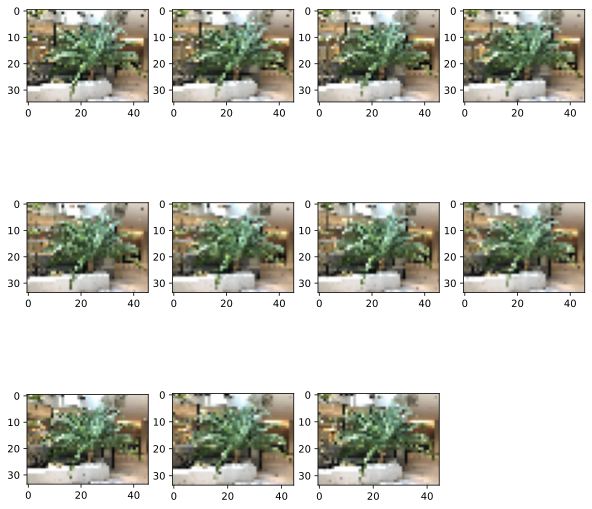

In [50]:
img_wh = img.shape[:2]
print(img_wh)

skips =  img_wh[0]//32
tw, th = 0, 0

grid_size =  int(np.sqrt(skips + 1))
print(grid_size, 1 + skips//grid_size)
plt.figure(0, figsize=(10, 10))

for ix in range(skips):
    seg = img[ix::skips, ix::skips]
    tw += seg.shape[0]
    th += seg.shape[1]
    print(seg.shape)
    plt.subplot(grid_size, 1 + skips//grid_size, ix+1)
    plt.imshow(seg.data.numpy())

print(tw, th)

In [51]:
46*32*64/(1024*32*4), 400//32

(0.71875, 12)

In [55]:
mg_wh = img.shape[:2]
print(img_wh)

skips1 =  img_wh[0]//32
skips2 =  img_wh[1]//32

main_skips = max(skips1, skips2)

tw, th = 0, 0

grid_size =  int(np.sqrt(skips + 1))
print(grid_size, 1 + skips//grid_size)
# plt.figure(0, figsize=(10, 10))

for ix in range(skips1):
    for iy in range(skips2):
        seg = img[ix::skips1, iy::skips2]
        tw += seg.shape[0]
        th += seg.shape[1]
        # print(seg.shape)
    # plt.subplot(grid_size, 1 + skips//grid_size, ix+1)
    # plt.imshow(seg.data.numpy())

print(tw, th)

torch.Size([378, 504])
3 4
5670 5544


In [56]:
img[0::12].shape

torch.Size([32, 504, 3])

In [157]:
im = np.ones_like(img)

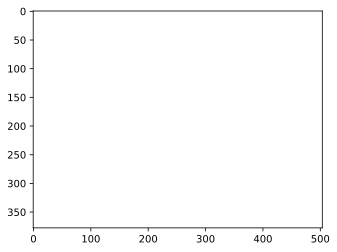

In [158]:
plt.imshow(im)

In [163]:
ix = 0
skips1 =  img_wh[0]//32
skips2 =  img_wh[1]//32

pairs = []
for i in range(skips1):
    for j in range(skips2):
        pairs.append([i, j])
print(len(pairs))

165


In [164]:
tot = 0
for t in range(len(pairs)):
    sw, sh = im[pairs[ix][0]::skips1, pairs[ix][1]::skips2].shape[:2]
    tot += sw*sh
    # plt.imshow(im)
    ix += 1

print(tot)

190512


In [166]:
img_wh[0] * img_wh[1]

190512

## Reconstruction Procedure

In [15]:
val_dataset = LLFF2DDataset('/ssd_scratch/cvit/shubham/nerf_llff_data/fern/', 'val', img_chunk=(100, 100))

val image is /ssd_scratch/cvit/shubham/nerf_llff_data/fern/images/IMG_4038.JPG


In [20]:
val_dataset.img_wh

(504, 378)

In [17]:
sample = val_dataset[0]
rays, rgbs = sample['rays'], sample['rgbs']
sample.keys()

dict_keys(['rays', 'c2w', 'rgbs'])

In [18]:
template = torch.zeros_like(rgbs)
template.shape

torch.Size([378, 504, 3])

In [19]:
tot = 0
if val_dataset.apply_skip:
    # Create a template for the outputs
    template = torch.zeros_like(rgbs)
    # Divide the data samples
    for sx in range(val_dataset.skips[0]):
        for sy in range(val_dataset.skips[1]):
            template
print(tot)

15


In [182]:
len(pairs)

16

In [ ]:
out = np.zeros_like(img)
assign = np.zeros(img.shape)


imsets = []

for ix in range(skp):
    for iy in range(skp):
        pass